In [ ]:
import diffrax
import jax
import jax.numpy as jnp
import numpy as np
from jax import random
import matplotlib.pyplot as plt
import diffrax as dfx

from pde_opt.numerics.domains import Domain
from pde_opt.numerics.shapes import Shape
from pde_opt.numerics.equations.allen_cahn import AllenCahn2DSmoothedBoundary
from pde_opt.pde_model import PDEModel

In [18]:
# Create a circular binary mask
binary_mask = np.zeros((100, 100))
center = (50, 50)
radius = 20
y, x = np.ogrid[:100, :100]
dist_from_center = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
binary_mask[dist_from_center <= radius] = 1

shape = Shape(
    binary=jnp.array(binary_mask),
    dx=(1.0, 1.0),
    smooth_epsilon=3.0,
    smooth_curvature=0.008,
    smooth_dt=0.01,
    smooth_tf=100.0,
)

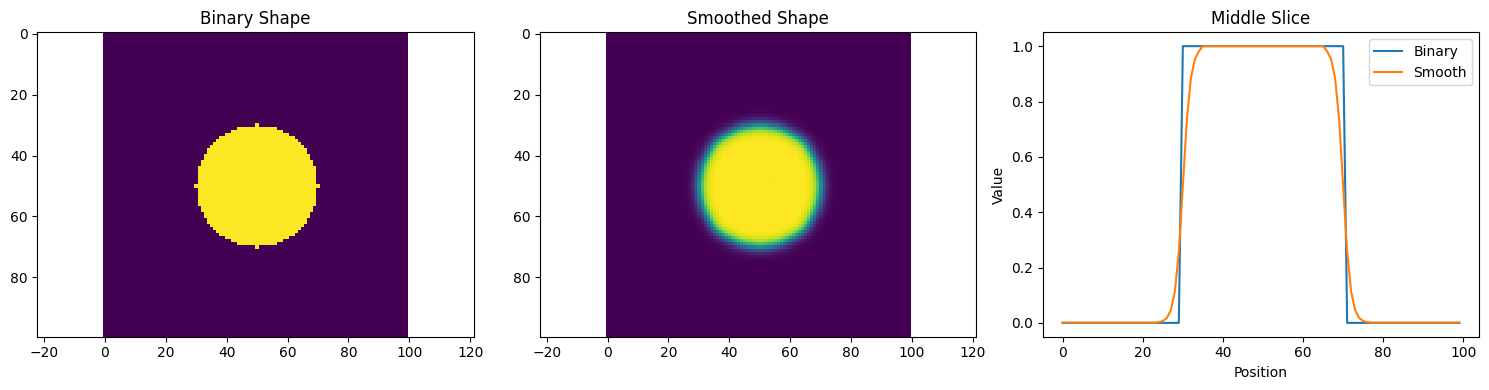

0.001
1.0


In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.imshow(shape.binary, cmap="viridis")
ax1.set_title("Binary Shape")
ax1.axis("equal")

ax2.imshow(shape.smooth, cmap="viridis")
ax2.set_title("Smoothed Shape")
ax2.axis("equal")

# Plot slice through middle
mid_idx = shape.binary.shape[0] // 2
ax3.plot(shape.binary[mid_idx, :], label="Binary")
ax3.plot(shape.smooth[mid_idx, :], label="Smooth")
ax3.set_title("Middle Slice")
ax3.set_xlabel("Position")
ax3.set_ylabel("Value")
ax3.legend()

plt.tight_layout()
plt.show()

print(jnp.min(shape.smooth))
print(jnp.max(shape.smooth))

In [9]:
shape.get_shape_modes(N=20)

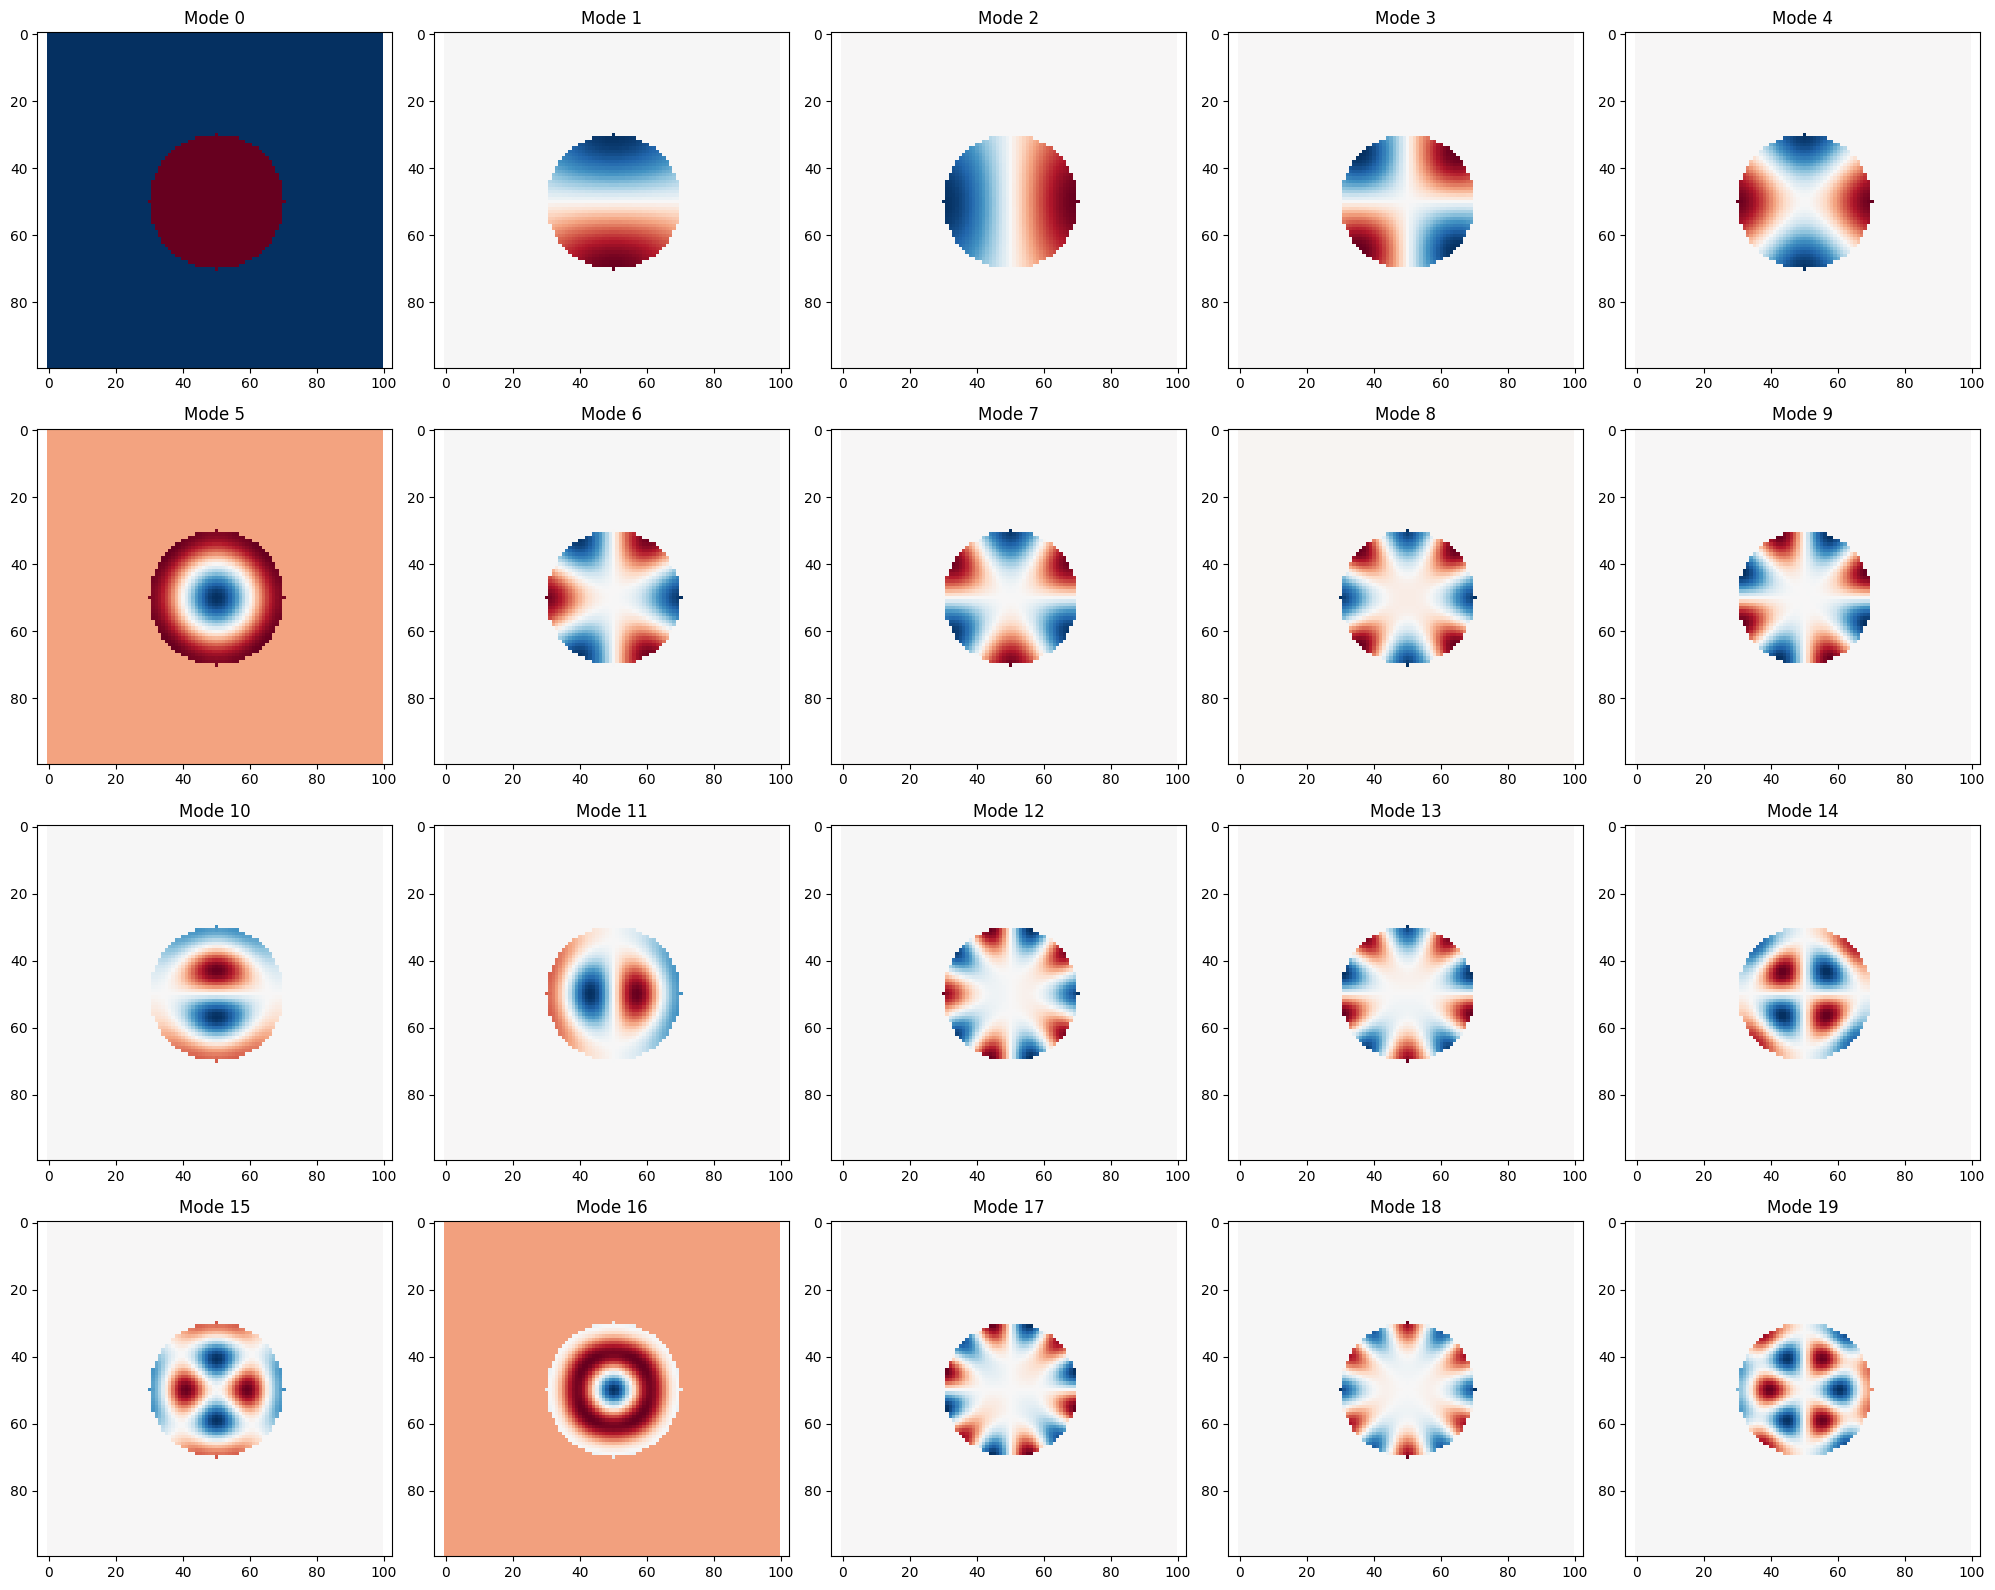

In [10]:
# Plot shape modes
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()

for i in range(20):
    axes[i].imshow(shape.shape_basis[:, :, i], cmap="RdBu")
    axes[i].set_title(f"Mode {i}")
    axes[i].axis("equal")

plt.tight_layout()
plt.show()

In [5]:
Nx, Ny = 100, 100
Lx = 0.01 * Nx
Ly = 0.01 * Ny
# Lx = 1.0 * Nx
# Ly = 1.0 * Ny
domain = Domain(
    (Nx, Ny), ((-Lx / 2, Lx / 2), (-Ly / 2, Ly / 2)), "dimensionless", shape
)

t_start = 0.0
t_final = 0.1
dt = 0.000001

ts_save = jnp.linspace(t_start, t_final, 200)

kappa = 0.002  # 1.0

In [6]:
eq = CahnHilliard2DSmoothedBoundary(
    domain,
    kappa,
    lambda c: c * jnp.log(c)
    + (1.0 - c) * jnp.log(1.0 - c)
    + 3.0 * c * (1.0 - c)
    + 0.059,
    lambda c: jnp.log(c / (1.0 - c)) + 3.0 * (1.0 - 2.0 * c),
    lambda c: (1.0 - c) * c,
    # lambda c: c**2 * (1.0 - c)**2,
    # lambda c: 2.0 * c - 4.0 * c**3,
    # lambda c: jnp.ones_like(c),
    lambda t: jnp.pi / 2.0,
    lambda t: 0.0,
    derivs="fd",
)

solver = dfx.Tsit5()

In [7]:
# eq = AllenCahn2DSmoothedBoundary(
#     domain,
#     kappa,
#     lambda c: c*jnp.log(c) + (1.0 - c)*jnp.log(1.0 - c) + 3.0*c*(1.0 - c) + 0.059,
#     lambda c: jnp.log(c / (1.0 - c)) + 3.0 * (1.0 - 2.0 * c),
#     lambda c: (1.0 - c) * c,
#     # lambda c: c**2 * (1.0 - c)**2,
#     # lambda c: 2.0 * c - 4.0 * c**3,
#     # lambda c: jnp.ones_like(c),
#     lambda t: jnp.pi / 3.0,
#     lambda t: 0.0,
#     derivs="fd"
# )

# solver = dfx.Tsit5()

In [8]:
key = random.PRNGKey(0)
# u0 = 0.5 * jnp.ones((Nx, Ny)) + 0.1 * random.normal(key, (Nx, Ny))
u0 = 0.9 * jnp.ones((Nx, Ny))
u0 = u0.at[:, :50].set(0.1)

solution = diffrax.diffeqsolve(
    diffrax.ODETerm(jax.jit(lambda t, y, args: eq.rhs(y, t))),
    solver,
    t0=t_start,
    t1=t_final,
    dt0=dt,
    y0=u0,
    stepsize_controller=diffrax.PIDController(rtol=1e-4, atol=1e-6),
    saveat=diffrax.SaveAt(ts=ts_save),
    max_steps=1000000,
)

print(solution.stats)

print(jnp.mean(solution.ys[0]))
print(jnp.mean(solution.ys[-1]))

{'max_steps': 1000000, 'num_accepted_steps': Array(94312, dtype=int64, weak_type=True), 'num_rejected_steps': Array(23578, dtype=int64, weak_type=True), 'num_steps': Array(117890, dtype=int64, weak_type=True)}
0.5
0.5005413430603102


In [9]:
print(jnp.mean(solution.ys[0][binary_mask == 1]))
print(jnp.mean(solution.ys[-1][binary_mask == 1]))

0.5130469371519492
0.5125660105037482


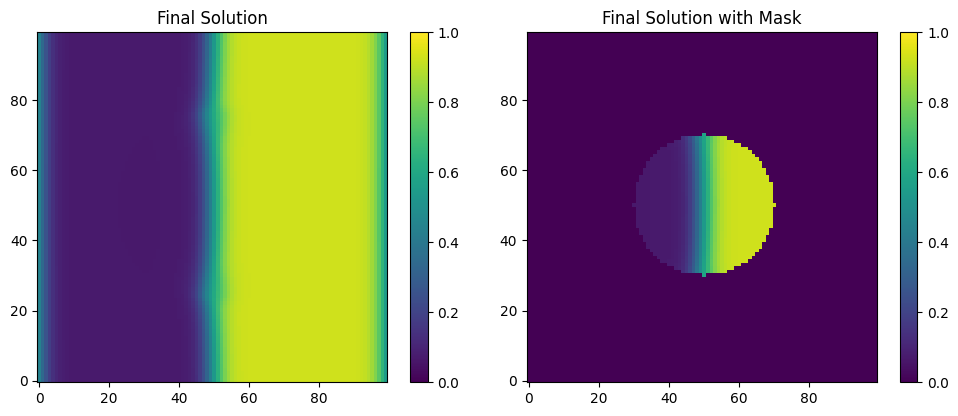

In [10]:
ind = -1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

im1 = ax1.imshow(solution.ys[ind], origin="lower", vmin=0.0, vmax=1.0)
ax1.set_title("Final Solution")
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(solution.ys[ind] * binary_mask, origin="lower", vmin=0.0, vmax=1.0)
ax2.set_title("Final Solution with Mask")
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

In [18]:
jnp.pi / 4.0

0.7853981633974483

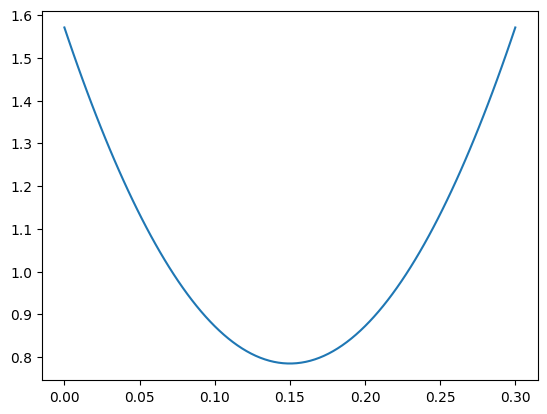

In [24]:
t = jnp.linspace(0.0, 0.3, 100)


def theta(t):
    return 34.9065850398866 * t**2 - 10.4719755119660 * t + jnp.pi / 2


plt.plot(t, theta(t))
plt.show()

In [25]:
eq = CahnHilliard2DSmoothedBoundary(
    domain,
    kappa,
    lambda c: c * jnp.log(c)
    + (1.0 - c) * jnp.log(1.0 - c)
    + 3.0 * c * (1.0 - c)
    + 0.059,
    lambda c: jnp.log(c / (1.0 - c)) + 3.0 * (1.0 - 2.0 * c),
    lambda c: (1.0 - c) * c,
    # lambda c: c**2 * (1.0 - c)**2,
    # lambda c: 2.0 * c - 4.0 * c**3,
    # lambda c: jnp.ones_like(c),
    lambda t: theta(t),
    lambda t: 0.0,
    derivs="fd",
)

In [30]:
solution2 = diffrax.diffeqsolve(
    diffrax.ODETerm(jax.jit(lambda t, y, args: eq.rhs(y, t))),
    solver,
    t0=t_start,
    t1=3.0 * t_final,
    dt0=dt,
    y0=solution.ys[-1],
    stepsize_controller=diffrax.PIDController(rtol=1e-4, atol=1e-6),
    saveat=diffrax.SaveAt(ts=jnp.linspace(t_start, 3.0 * t_final, 200)),
    max_steps=1000000,
)

print(solution2.stats)

print(jnp.mean(solution2.ys[0]))
print(jnp.mean(solution2.ys[-1]))

{'max_steps': 1000000, 'num_accepted_steps': Array(282103, dtype=int64, weak_type=True), 'num_rejected_steps': Array(70001, dtype=int64, weak_type=True), 'num_steps': Array(352104, dtype=int64, weak_type=True)}
0.5005413430603102
0.49956635521872006


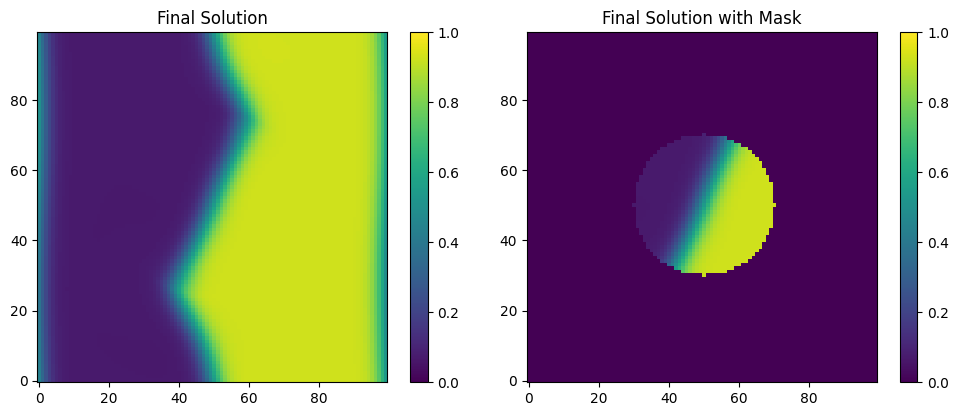

In [31]:
ind = -1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

im1 = ax1.imshow(solution2.ys[ind], origin="lower", vmin=0.0, vmax=1.0)
ax1.set_title("Final Solution")
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(solution2.ys[ind] * binary_mask, origin="lower", vmin=0.0, vmax=1.0)
ax2.set_title("Final Solution with Mask")
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

In [32]:
solution2.ts[-1]

Array(0.3, dtype=float64)

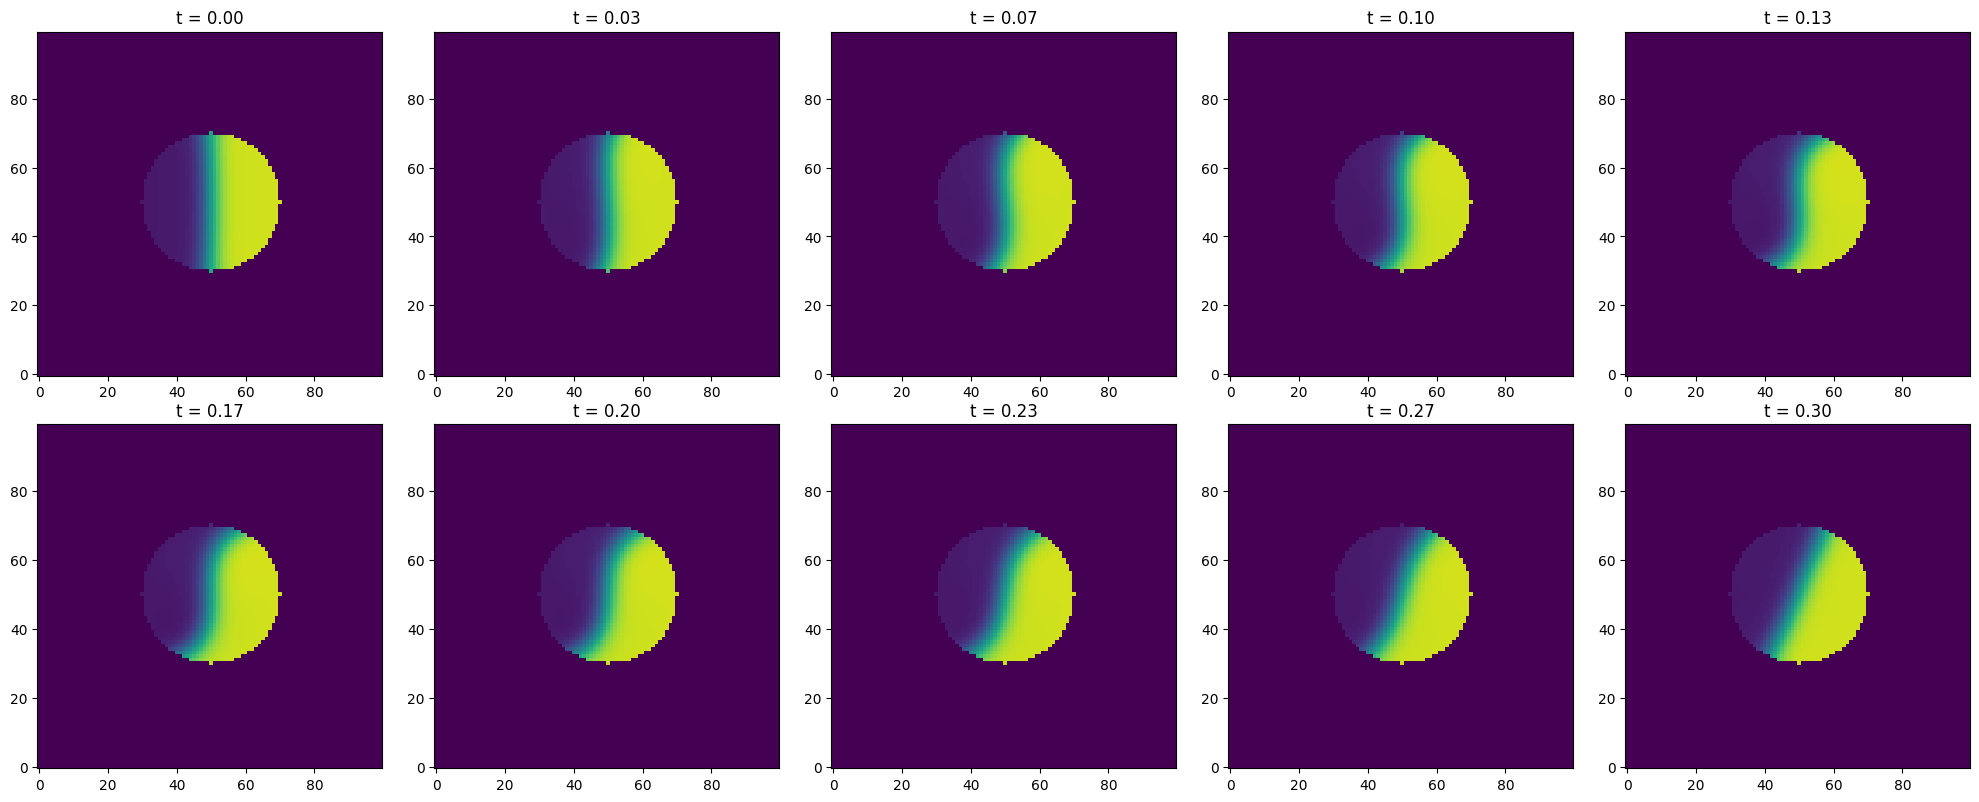

In [33]:
indices = jnp.linspace(0, len(solution2.ys) - 1, 10, dtype=int)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, idx in enumerate(indices):
    im = axes[i].imshow(
        solution2.ys[idx] * binary_mask, origin="lower", vmin=0.0, vmax=1.0
    )
    axes[i].set_title(f"t = {solution2.ts[idx]:.2f}")
    # plt.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()